<a href="https://colab.research.google.com/github/quanvu0996/models/blob/master/Movielen_ClusterRecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Enviroment setting
import tensorflow as tf
from tensorflow.keras import layers
from keras import backend as K
import pprint

import requests
import sys

import numpy as np
import re
from scipy.sparse import csr_matrix, hstack
import pandas as pd
from pandas.api.types import CategoricalDtype
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Tải dữ liệu về (chỉ tải 1 lần, lưu về drive => từ lần sau chỉ việc load lại)
# file_url = 'https://files.grouplens.org/datasets/movielens/ml-20m.zip'
# file_path = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m.zip"

# r = requests.get(file_url, stream = True) 

# with open( file_path, "wb") as file: 
#     for block in r.iter_content(chunk_size = 1024*10): 
#         if block: 
#             file.write(block)

In [4]:
# !unzip /content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m.zip -d /content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/

In [5]:
itemCol = 'movieId'
userCol = 'userId'

fpath = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m"

In [6]:
def fn_year(x):
    x = re.findall('\(\d{4}\)$',x['title'])
    if len(x) >0:
        return x[0][1:5]
    else:
        return None

movies = pd.read_csv(fpath+'/movies.csv')
movies['release_year'] = movies.apply( fn_year , axis=1)
movies["genre_arr"] = movies['genres'].apply(lambda x: x.split('|'))

In [7]:
ratings = pd.read_csv(fpath+'/ratings.csv')

In [8]:
# item-wise split
# test_year = '2005'
# valid_year = '1996'
# ft_movies = movies[movies['release_year']<= valid_year]
# lb_movies = movies[(movies['release_year']> valid_year) & (movies['release_year'] <= test_year)]
# test_movies = movies[movies['release_year']> test_year]

# ft_movies.movieId.count(), lb_movies.movieId.count(), test_movies.movieId.count()

In [9]:
def user_wise_split(df, userCol, itemCol, test_size=0.25):
    all_user = df[userCol].drop_duplicates()
    train_user, test_user = train_test_split(all_user, test_size=test_size)

    train_ratings = df[df[itemCol].isin(train_user)]
    test_ratings = df[df[itemCol].isin(test_user)]
    return train_ratings, test_ratings

train_val, test = train_test_split(ratings, test_size= 0.25)
train, valid = user_wise_split(train_val,userCol, itemCol, test_size=0.25 )
train.head()

,userId,movieId,rating,timestamp
12790432,88397,102684,4.5,1400979791
5477865,37640,10,3.5,1280382521
1593524,10759,60397,0.5,1256101033
17017965,117716,2115,5.0,985766103
18134707,125459,1918,4.0,1299356306


# Simple CF

In [35]:
# train["y"] = train["rating"]/5
u_encoder = sklearn.preprocessing.LabelEncoder()
i_encoder = sklearn.preprocessing.LabelEncoder()

train["u"] = u_encoder.fit_transform(train[[userCol]])
train["i"] = i_encoder.fit_transform(train[[itemCol]])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
u_num = ratings[userCol].drop_duplicates().count()
i_num = ratings[itemCol].drop_duplicates().count()

u_embedding_size = 1000
i_embedding_size = 100

u_clusters = 100
i_clusters = 50

embedding_size = 100

# user
u_input = layers.Input(shape=(1,))
u = layers.Embedding( input_dim= u_num, output_dim= u_embedding_size)(u_input)
u = layers.Dense( u_clusters, activation= 'sigmoid' )(u)
u = layers.Dense( embedding_size, activation= 'relu')(u)
u = layers.Reshape( target_shape=(embedding_size,))(u)

# item
i_input = layers.Input(shape=(1,))
i = layers.Embedding( input_dim= i_num, output_dim= i_embedding_size)(i_input)
i = layers.Dense( i_clusters, activation= 'sigmoid' )(i)
i = layers.Dense( embedding_size, activation= 'relu')(i)
i = layers.Reshape( target_shape=(embedding_size,))(i)

dot = layers.Dot(normalize= True, axes=1)([u, i])
out = layers.Dense( units=1, activation='linear')(dot)

# compile
model = tf.keras.models.Model(inputs= [u_input, i_input], outputs= out )
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 1, 1000)      138493000   ['input_21[0][0]']               
                                                                                                  
 embedding_21 (Embedding)       (None, 1, 100)       2674400     ['input_22[0][0]']               
                                                                                            

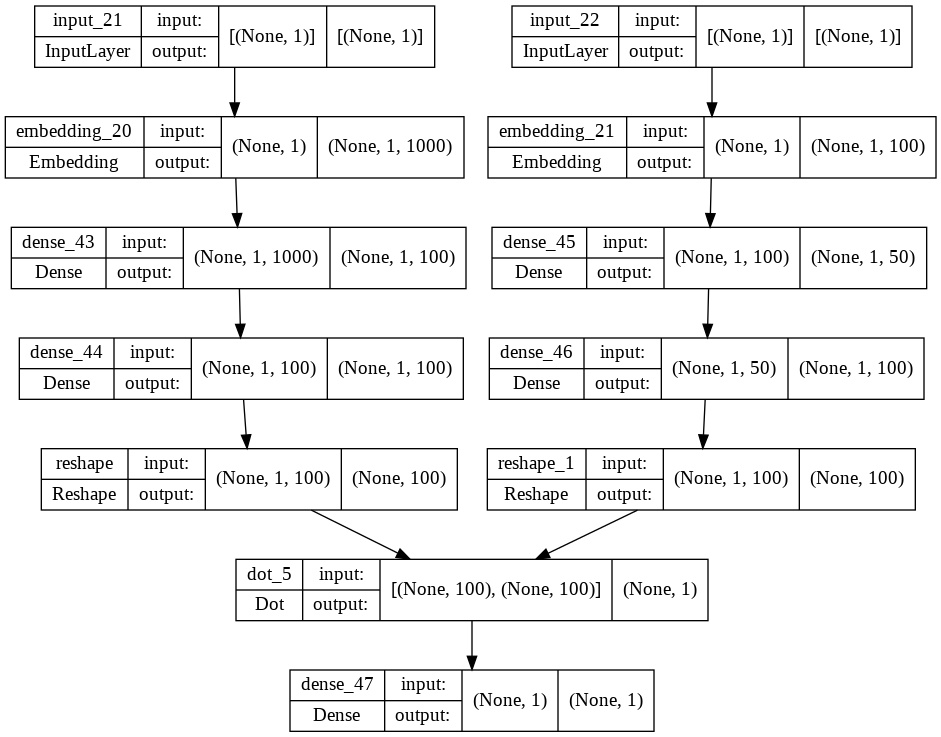

In [31]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train
training = model.fit(x=[train["u"], train["i"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
# utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

MODELING

In [ ]:
# Loss function
def Focus2(alpha=0.01):
    def cal_los(y_true, y_pred):
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        positive_true = y_true[y_true!=0]
        positive_pred = y_pred[y_true!=0]
        los1 = K.square(positive_true-positive_pred )

        zero_true = y_true[y_true==0]
        zero_pred = y_pred[y_true==0]
        los2 =alpha*  K.square(zero_true-zero_pred )


        return K.mean( tf.concat([los1, los2], axis=0) )
    return cal_los

y_true = tf.constant([1,0.2,0,1])
y_pred = tf.constant([1,0,5.2,1.005])

Focus2(0.01)(y_true, y_pred)


<tf.Tensor: shape=(), dtype=float32, numpy=0.07760624>

In [ ]:
# EVALUATION Function
def checkbox_rating(ratings, split_level = 3):
  "Convert ratings thang 5 điểm về binary"
  return np.where( ratings > split_level, 1, 0)

def pair_iou(r1, r2):
  """Cho 2 bộ: rating1, rating2, dạng onehot => tính IOU"""
  inter = np.multiply(r1,r2) > 0
  union = (r1+r2) > 0

  if np.sum(union) ==0:
    return None
  else:
    inters = np.sum(inter, axis=1)
    unions = np.sum(union, axis=1)
    iou = np.mean(inters[unions>0]/unions[unions>0])
    return iou 

def list_iou(ratings_):
  ratings = ratings_.copy()
  n = ratings.shape[0]
  np.random.shuffle(ratings)

  @delayed
  def f_iou_i(i):
      shift_ratings = np.roll(ratings, i+1)
      iou_i = pair_iou(ratings, shift_ratings)
      return iou_i


  ious = Parallel(n_jobs=-1, backend = "threading")(f_iou_i(i) for i in range(10))
  return np.mean(ious)


def iou_cluster(Y_true, y_cluster_pred):
    ious = []
    for i in np.unique(y_cluster_pred):
        ratings = Y_true[y_cluster_pred == i]
        ious.append(list_iou(ratings))
    return np.mean(ious), ious

SIMPLE CF

In [ ]:
# Pivot value, keeping just top_item popular the most
def get_cf_ft(ratings, top_item = 300):
    top_items = list(train.groupby(itemCol).count()["rating"].sort_values(ascending=False)\
                     .head(top_item).index)
    ratings_ = ratings[ratings[itemCol].isin(top_items)]
    cf_fts= ratings_.pivot(index=userCol, columns=itemCol, values = "rating")
    return cf_fts

# Get feature and label, random spliting from a full dataset
def get_ft_lb(ratings, test_size=0.25, top_item=300):
    ft, lb = train_test_split(ratings, test_size= test_size)
    ft_pv = get_cf_ft(ft, top_item)
    lb_pv = get_cf_ft(ft, top_item)

    X = ft_pv.values
    y = lb_pv.reindex(ft_pv.index).values
    return X, y, ft_pv.index
X_cf, y, user_ind = get_ft_lb(train, test_size=0.25)


In [ ]:
X_cf.shape, y.shape

((136136, 300), (136136, 300))

In [ ]:
# Math model
n_ft = X_cf.shape[1]
n_clusters = 25
n_lb = y.shape[1]
model = tf.keras.Sequential([
          tf.keras.layers.Input(n_ft),
          tf.keras.layers.Dense(n_clusters, activation='softmax'),
        #   tf.keras.layers.Dense(int(n_clusters/4), activation='softmax'),
          tf.keras.layers.Dense(n_lb)
])

model.compile( optimizer='adam', loss= Focus2(0.05))
model.fit(np.nan_to_num(X_cf), np.nan_to_num(y), epochs=5, batch_size=64)

Epoch 1/5
2130/2130 [==============================] - 11s 5ms/step - loss: 0.6520
Epoch 2/5
2130/2130 [==============================] - 6s 3ms/step - loss: 0.3364
Epoch 3/5
2130/2130 [==============================] - 6s 3ms/step - loss: 0.3135
Epoch 4/5
2130/2130 [==============================] - 6s 3ms/step - loss: 0.3051
Epoch 5/5
2130/2130 [==============================] - 6s 3ms/step - loss: 0.2985


In [ ]:
lv1 = model.layers[0](np.nan_to_num(X_cf))
lv1_ind = np.argmax(lv1, axis=1)
k=10
print(lv1[k], lv1_ind[k])

for i in np.unique(lv1_ind):
    print(i,":", np.sum(lv1_ind==i))

tf.Tensor(
[0.0000000e+00 3.6926485e-07 5.2853051e-05 6.3609052e-04 0.0000000e+00
 0.0000000e+00 3.9632429e-11 7.7724529e-18 0.0000000e+00 0.0000000e+00
 1.8855225e-16 0.0000000e+00 0.0000000e+00 8.2715757e-02 0.0000000e+00
 0.0000000e+00 5.6058341e-17 0.0000000e+00 4.5427034e-14 9.1464311e-01
 0.0000000e+00 1.9518479e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00], shape=(25,), dtype=float32) 19
1 : 4263
2 : 12602
3 : 5991
6 : 25947
7 : 1028
10 : 7444
13 : 16617
16 : 13778
18 : 8751
19 : 32770
21 : 7081


In [ ]:
def iou_cluster(Y_true, y_cluster_pred):
    ious = []
    ns = []
    for i in np.unique(y_cluster_pred):
        ratings = Y_true[y_cluster_pred == i]
        ns.append(ratings.shape[0])
        ious.append(list_iou(ratings))
    ns_arr = np.array(ns)
    ious_arr = np.array(ious)
    return np.sum(ns_arr*ious_arr)/np.sum(ns_arr)

In [ ]:
y_checkbox = checkbox_rating(y)
iou = iou_cluster(y_checkbox, lv1_ind)
print(iou)

0.04855981074605795


In [ ]:
# lv2 = model.layers[1](lv1)
# lv2_ind = np.argmax(lv2, axis=1)
# for i in np.unique(lv2_ind):
#     print(i,":", np.sum(lv2_ind==i))

# CF + CB model

In [ ]:
%%time
def vectorize_arr(movies, itemCol, arrCol, outCol = "genre_vec"):

    out = movies.explode(arrCol)
    columns = out[arrCol].drop_duplicates()
    out["value"]=1

    out = out.pivot(index=itemCol, columns = arrCol, values="value").fillna(0)
    out[outCol] = out.apply(lambda x: np.array(x[columns]), axis=1)
    return out.drop(columns, axis=1)

def cb_ft(ratings, movies,userCol ,itemCol, user_ind=None):
    movie_attr = vectorize_arr(movies,itemCol, arrCol='genre_arr')
    train_ft = ratings.merge(movie_attr, on=itemCol)
    train_ft['rating_attr'] = train_ft['rating'] * train_ft['genre_vec']
    train_ft_byu = train_ft.groupby(userCol).agg({'rating_attr':"mean"})
    if user_ind is not None:
        train_ft_byu = train_ft_byu.reindex(user_ind)
        
    list_ar = [x[0] for x in train_ft_byu.values]
    X_cb = np.stack(list_ar, axis=0)
    return X_cb

X_cfcb = np.hstack([np.nan_to_num(X_cf),
                   cb_ft(train, movies, userCol ,itemCol, user_ind)
                   ])

CPU times: user 1min 24s, sys: 28.7 s, total: 1min 53s
Wall time: 1min 54s


In [ ]:
X_cfcb.shape

(136272, 320)

In [ ]:
# Math model
n_ft = X_cfcb.shape[1]
n_clusters = 25
n_lb = y.shape[1]
model2 = tf.keras.Sequential([
          tf.keras.layers.Input(n_ft),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dense(n_clusters, activation='softmax'),
        #   tf.keras.layers.Dense(int(n_clusters/4), activation='softmax'),
          tf.keras.layers.Dense(n_lb)
])

model2.compile( optimizer='adam', loss= Focus2(0.01) )
model2.fit(np.nan_to_num(X_cfcb), np.nan_to_num(y), epochs=5, batch_size=128)

Epoch 1/5
1065/1065 [==============================] - 6s 4ms/step - loss: 0.7661
Epoch 2/5
1065/1065 [==============================] - 5s 5ms/step - loss: 0.2833
Epoch 3/5
1065/1065 [==============================] - 5s 4ms/step - loss: 0.1885
Epoch 4/5
1065/1065 [==============================] - 5s 5ms/step - loss: 0.1665
Epoch 5/5
1065/1065 [==============================] - 5s 4ms/step - loss: 0.1520


In [ ]:
lv1_2 = model2.layers[1](model2.layers[0](np.nan_to_num(X_cfcb)))
lv1_ind_2 = np.argmax(lv1_2, axis=1)
print(lv1_2[1])

for i in np.unique(lv1_ind_2):
    print(i,":", np.sum(lv1_ind_2==i))

y_checkbox = checkbox_rating(y)
iou = iou_cluster(y_checkbox, lv1_ind_2)
print(iou)

tf.Tensor(
[4.8878923e-02 9.0589845e-01 3.3117320e-02 5.5799336e-07 1.5746822e-07
 1.2319317e-07 6.5119423e-07 5.5146280e-08 1.4830492e-06 1.6900875e-06
 4.9764600e-07 2.0810081e-07 5.8337026e-08 1.2091854e-02 1.6287899e-07
 1.0708258e-06 1.2668285e-07 1.3519192e-06 1.2261555e-07 1.2528376e-07
 7.5136279e-07 4.2966337e-07 2.1386481e-06 1.3521255e-06 2.5005508e-07], shape=(25,), dtype=float32)
0 : 5308
1 : 65836
2 : 34350
13 : 30778


In [ ]:
y_checkbox = checkbox_rating(y)
iou = iou_cluster(y_checkbox, lv1_ind_2)
print(iou)

0.048564875860609744


In [ ]:
iou

(0.038822547957990214,
 [0.027230876383575443,
  0.06755595101438942,
  0.045932047038996386,
  0.014571317394999598])

In [ ]:
y[lv1_ind==12].shape

(104861, 300)

BASELINE: KMEANS

In [ ]:
# KMeans với CF feature
km1 = sklearn.cluster.KMeans(30)
km1.fit(np.nan_to_num(X_cf), np.nan_to_num(y))

km1_ind = km1.predict(np.nan_to_num(X_cf))

for i in np.unique(km1_ind):
    print(i,":", np.sum(km1_ind==i))

0 : 3735
1 : 5103
2 : 3651
3 : 28236
4 : 1509
5 : 3148
6 : 4910
7 : 2662
8 : 6337
9 : 3585
10 : 2228
11 : 1786
12 : 6835
13 : 3643
14 : 2033
15 : 2290
16 : 3362
17 : 2511
18 : 3025
19 : 5205
20 : 3667
21 : 6933
22 : 4172
23 : 1573
24 : 6591
25 : 2814
26 : 3778
27 : 2502
28 : 4262
29 : 4050


In [ ]:
# y_checkbox = checkbox_rating(y)
iou = iou_cluster(y_checkbox, km1_ind)
print(iou)

(0.06551109004538001, [0.051300102585774984, 0.024365192655966185, 0.024853163246359635, 0.012001319227133296, 0.13953685576858874, 0.0863151013176753, 0.02049251018616803, 0.04047797321867961, 0.04666130208628209, 0.05339072562487931, 0.10854351726650686, 0.1278108318481522, 0.031377193193344366, 0.052143698341301746, 0.09662009655961872, 0.08652585303063909, 0.04474056012962516, 0.13370837388353732, 0.09422166863419022, 0.018045335464669805, 0.05495235832424149, 0.016045409855348275, 0.05266900652944258, 0.1924594570116518, 0.034510061426268855, 0.0634149293147595, 0.03568962978827072, 0.09209952917513056, 0.04023548441702231, 0.09012546125017165])


In [ ]:
# KMeans với CFCB feature
km2 = sklearn.cluster.KMeans()
km2.fit(np.nan_to_num(X_cfcb), np.nan_to_num(y))

km2_ind = km2.predict(np.nan_to_num(X_cfcb))

for i in np.unique(km2_ind):
    print(i,":", np.sum(km2_ind==i))

0 : 51748
1 : 21094
2 : 17926
3 : 7592
4 : 10956
5 : 6193
6 : 9278
7 : 11485


In [ ]:
# y_checkbox = checkbox_rating(y)
iou = iou_cluster(y_checkbox, km2_ind)
print(iou)

0.04851188868586251


Kmeans-supervised

In [ ]:
# KMeans với CFCB feature
n_clusters = 30
kmy = sklearn.cluster.KMeans(n_clusters)
kmy.fit(np.nan_to_num(y))

y_clust = kmy.predict(np.nan_to_num(y))

for i in np.unique(y_clust):
    print(i,":", np.sum(y_clust==i))

0 : 2817
1 : 4216
2 : 3172
3 : 6868
4 : 2416
5 : 4728
6 : 5508
7 : 7074
8 : 3375
9 : 1501
10 : 1661
11 : 1640
12 : 3887
13 : 2080
14 : 3660
15 : 4133
16 : 2578
17 : 3845
18 : 4123
19 : 5229
20 : 5355
21 : 2041
22 : 4810
23 : 5154
24 : 2297
25 : 28430
26 : 3026
27 : 3906
28 : 3963
29 : 2643


In [ ]:
# Math model
n_ft = X_cf.shape[1]
n_lb = y.shape[1]
model = tf.keras.Sequential([
          tf.keras.layers.Input(n_ft),
          tf.keras.layers.Dense(n_clusters, activation='softmax')
])

model.compile( optimizer='adam', loss='categorical_crossentropy', metrics = ["accuracy"])
model.fit(np.nan_to_num(X_cf), tf.keras.utils.to_categorical(y_clust), epochs=5, batch_size=64)

Epoch 1/5
2128/2128 [==============================] - 6s 2ms/step - loss: 1.2968 - accuracy: 0.6352
Epoch 2/5
2128/2128 [==============================] - 3s 2ms/step - loss: 0.6299 - accuracy: 0.8041
Epoch 3/5
2128/2128 [==============================] - 3s 2ms/step - loss: 0.4999 - accuracy: 0.8304
Epoch 4/5
2128/2128 [==============================] - 3s 2ms/step - loss: 0.4397 - accuracy: 0.8459
Epoch 5/5
2128/2128 [==============================] - 3s 2ms/step - loss: 0.4036 - accuracy: 0.8558


In [ ]:
y_pred_prob = model.layers[0](np.nan_to_num(X_cf))
y_pred_clus = np.argmax(y_pred_prob, axis=1)

for i in np.unique(y_pred_clus):
    print(i,":", np.sum(y_pred_clus==i))

y_checkbox = checkbox_rating(y)
iou = iou_cluster(y_checkbox, y_pred_clus)
print(iou)

0 : 3184
1 : 4254
2 : 3204
3 : 7025
4 : 2364
5 : 4490
6 : 5680
7 : 7194
8 : 3277
9 : 1580
10 : 1760
11 : 1847
12 : 4025
13 : 2269
14 : 3501
15 : 3928
16 : 2839
17 : 4378
18 : 4173
19 : 5091
20 : 5305
21 : 2155
22 : 5159
23 : 5322
24 : 2564
25 : 28099
26 : 2444
27 : 3373
28 : 3471
29 : 2181
(0.06441493103959742, [0.0635124326354414, 0.04321827606823396, 0.08222716563117302, 0.031052090389102376, 0.12541580600285307, 0.03944720514375409, 0.0364853074924961, 0.01586036800972653, 0.05524769714956853, 0.1672099157553426, 0.12021523947539352, 0.12786506623050645, 0.08388571266507093, 0.10748239209560642, 0.0434012803464212, 0.032169781632162775, 0.06599227042592934, 0.07069585256354015, 0.0529180897803692, 0.01834785207477414, 0.024400364093429466, 0.09176428643167274, 0.04740704883718473, 0.022368895219431813, 0.09419788985266404, 0.012476548391453565, 0.07838794549733281, 0.04101012212405657, 0.048852387729193356, 0.08893264144403755])


EVALUATION

In [ ]:
%%time
# y_checkbox = checkbox_rating(y)
iou = iou_cluster(y_checkbox, lv1_ind)
iou

CPU times: user 8.21 s, sys: 535 ms, total: 8.75 s
Wall time: 6.53 s


In [ ]:
iou

(0.04908920674218443,
 [0.04986259549791176,
  0.048524567452345894,
  0.04903010774764126,
  0.04918971024521553,
  0.051314851740290414,
  0.04847542653007918,
  0.048861613324826005,
  0.04891807578062232,
  0.04830921677197546,
  0.04891970371456544,
  0.04857540535855545])

In [ ]:
k = 10
r1 = y_checkbox[lv1_ind== k]
shift_r1 = np.roll(r1, 10)
iou_i = pair_iou(shift_r1, r1 )
iou_i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


nan

In [ ]:
import gc
gc.collect()

858

0.6666666666666666


In [ ]:
iou_i

0.04487990623572415

In [ ]:
np.unique(lv1_ind)

array([ 1,  2,  3,  6,  7, 10, 13, 16, 18, 19, 21])